# ERK2 Compounds: Molecular descriptors using RDKit

In [14]:
import pandas as pd
import numpy as np

In [17]:
### Load the data and create the molecules dataframe

In [39]:
# First lets load the data
df_csar = pd.read_json('./CSAR_39_used_by_Fourches.json')
df_model = pd.read_json('./CHEMBL4040_47mols_used_by_Fourches_erk2.json')

# For now, we are only interested in Names, SMILES (csar have isomeric smiles) and pKi
df_csar = df_csar[['Name_fourches', 'pKi', 'mol']]
df_model = df_model[['Name_fourches', 'pKi', 'canonical_smiles']]

# Rename the columns to simplify the dataframe
col_names_ = ['Name', 'pKi', 'smiles']
df_csar.columns = col_names_
df_model.columns = col_names_

# Now, concat the dataframes
df_erk2_mols = pd.concat([df_csar, df_model], ignore_index=True)

# Now, let's create a two new columns to account for activity according to Fourches
# Molecules with a pKi >= 7.5 will be considered as actives
df_erk2_mols['activity'] = (df_erk2_mols.pKi >= 7.5).astype(int)
df_erk2_mols['activity_label'] = ['active' if i else 'inactive' for i in df_erk2_mols.activity]

In [41]:
df_erk2_mols.head()

,Name,pKi,smiles,activity,activity_label
0,CSAR_erk2_18,9.00,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NC(C)C)...,1,active
1,CSAR_erk2_20,8.70,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
2,CSAR_erk2_17,8.52,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
3,CSAR_erk2_16,8.40,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
4,CSAR_erk2_15,8.40,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NCC)c1c...,1,active


In [84]:
# Save the dataframe
df_erk2_mols.to_json('./ERK2_molecules_used_by_Fourches_SMILES.json')

In [42]:
### Use rdkit to compute molecule rdkit objects

In [43]:
from rdkit import Chem

RDKit WARNING: [16:10:49] Enabling RDKit 2019.09.1 jupyter extensions


In [50]:
# Add the new column with the RDKit molecules
df_erk2_mols['rdk_mol'] = [Chem.MolFromSmiles(i, sanitize=True) for i in df_erk2_mols.smiles]

## MACCS Keys fingerprints

In [80]:
from rdkit.Chem import MACCSkeys

# Compute the fingerprints over the whole set of molecules
df_erk2_mols['maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in df_erk2_mols.rdk_mol]

In [194]:
# Example of MACC Keys Fingepirnt for molecule 1
df_erk2_mols.maccs[0].ToBitString()

'00000000000000000000000001000000000000000000000000000010000000100100000000100101101100000000100110100000101001110000010011000100000101010101011011000111011111111111110'

## 2D-RDKit molecular descriptors

Apparently this set of 117 descriptors is available through KNIME, specifically by the use of "[RDKit Descriptor Calculation](https://nodepit.com/node/org.rdkit.knime.nodes.descriptorcalculation.DescriptorCalculationNodeFactory)" node, which use a java wrapper to execute rdkit inside a KNIME pipeline ([code here](https://github.com/rdkit/knime-rdkit/blob/2616f9fa3c56107825ae26f3435a7733b1658251/org.rdkit.knime.nodes/src/org/rdkit/knime/nodes/descriptorcalculation/Descriptor.java)).

Because all these descriptors are directly available in RDKit's python library, we are going to compute them directly:

In [76]:
# Firts, let's import the available list  of descriptors
from rdkit.Chem import Descriptors
# Get the descriptor names but ommit all descriptors related to fragments inside molecules (all of them start with 'fr_')
names_of_all_rdkit_descriptors = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
# Number of descriptor available:
len(names_of_all_rdkit_descriptors)

115

Now, let's use the 'MolecularDescriptorCalculator' class, which takes a list of rdkit descriptors names and compute them on a given molecule.

In [82]:
from rdkit.ML.Descriptors import MoleculeDescriptors
# rdkit descriptor calculator
rdk_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(names_of_all_rdkit_descriptors)

In [83]:
# Now let's compute the fingerprints over the molecules
df_erk2_mols['2d_rdkit'] = [rdk_calculator.CalcDescriptors(mol = i) for i in df_erk2_mols.rdk_mol]

## WHIM descriptors

In [ ]:
from rdkit.Chem import rdMolDescriptors
from glob import glob

The list of WHIM descriptors computed by RDKit is the following:

In [111]:
whim_axial = [ "L1u", "L2u", "L3u", "P1u", "P2u", "G1u", "G2u", "G3u", "E1u", "E2u", "E3u", 
               "L1m", "L2m", "L3m", "P1m", "P2m", "G1m", "G2m", "G3m", "E1m", "E2m", "E3m", 
               "L1v", "L2v", "L3v", "P1v", "P2v", "G1v", "G2v", "G3v", "E1v", "E2v", "E3v", 
               "L1e", "L2e", "L3e", "P1e", "P2e", "G1e", "G2e", "G3e", "E1e", "E2e", "E3e", 
               "L1p", "L2p", "L3p", "P1p", "P2p", "G1p", "G2p", "G3p", "E1p", "E2p", "E3p", 
               "L1i", "L2i", "L3i", "P1i", "P2i", "G1i", "G2i", "G3i", "E1i", "E2i", "E3i", 
               "L1s", "L2s", "L3s", "P1s", "P2s", "G1s", "G2s", "G3s", "E1s", "E2s", "E3s"]
whim_global = ["Tu", "Tm", "Tv", "Te", "Tp", "Ti", "Ts", 
               "Au", "Am", "Av", "Ae", "Ap", "Ai", "As", 
               "Gu", "Gm", 
               "Ku", "Km", "Kv", "Ke", "Kp", "Ki", "Ks", 
               "Du", "Dm", "Dv", "De", "Dp", "Di", "Ds", 
               "Vu", "Vm", "Vv", "Ve", "Vp", "Vi", "Vs"]

whim_descriptors_names = whim_axial + whim_global

In [113]:
print('There are', len(whim_descriptors_names), 'WHIM descriptors.')
len(whim_axial)

There are 114 WHIM descriptors.


77

### About descriptors computed by KNIME
Fourches & Ash indicate that they compute the descriptors using KNIME. We analyze  
**Other notebook**

### Computed from a minimized conformation

In [172]:
# Directory of sdf files: 3D conformations created and minimized using babel
SDF_MIN_DIR = '../../ARCHIVOS/CRISTALES/LIGS_ERK2/FOURCHES_LIGS/3d_minimized/sdf/'

# List of sdf files
sdf_min_files = [SDF_MIN_DIR + i + '.sdf' for i in df_erk2_mols.Name] # keep the same order as the dataframe

# Read the files using RDkit
min_3d_confs = [Chem.SDMolSupplier(mol_file, sanitize=True)[0] for mol_file in sdf_min_files]

# Add minimized confs to the table
df_erk2_mols['conf_3d_min'] = min_3d_confs

# Compute WHIM descriptors for 3d min conformations
df_erk2_mols['whim_3d_min'] = [rdMolDescriptors.CalcWHIM(i) for i in df_erk2_mols.conf_3d_min]

### Computed from the best pose using the 3i60 conformation (the one used by Fourches)

In [188]:
# Directory of sdf files generated from the best docking poses
# Folders inside this directory belong to each ligand
SDF_DOCKED_DIR = '../../ARCHIVOS/CRISTALES/LIGS_ERK2/FOURCHES_LIGS/3d_minimized/docking_results_CRYS_ENS/VINARDO_POSES/SDF/'
pdb_3i60 = '3i60'

# List of sdf files (files are sorted as)
sdf_3i60_files = [glob(SDF_DOCKED_DIR + i + '/*' + pdb_3i60 + '*.sdf')[0] for i in df_erk2_mols.Name]

# Read the files using RDkit
# If  sanitization is not possible (ligs erk2_29 and erk2_12), we need to force rdkit
dk_3i60_confs = []
print('Molecules not sanitized at loading:')
for mol_file in sdf_3i60_files:
    mol_rdk = Chem.SDMolSupplier(mol_file, sanitize = True)[0]
    # If sanitize was not possible, molecule will be == None
    if mol_rdk == None:
        print(mol_file.split('/')[-1])
        mol_rdk  = Chem.SDMolSupplier(mol_file, sanitize = False)[0]
        mol_rdk.UpdatePropertyCache(strict = False)
    # Append  the molecule
    dk_3i60_confs.append(mol_rdk)
    
# Add docked poses to 3i60 confs to the table
df_erk2_mols['conf_3i60_dk_pose'] = dk_3i60_confs

# Compute WHIM descriptors for  3i60 poses
df_erk2_mols['whim_3i60_dk_pose'] = [rdMolDescriptors.CalcWHIM(i) for i in df_erk2_mols.conf_3i60_dk_pose]

Molecules not sanitized at loading:
erk2_29_3i60_dkVin.sdf
erk2_12_3i60_dkVin.sdf


RDKit ERROR: [15:21:54] ERROR: Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:22:24] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:22:24] ERROR: Could not sanitize molecule ending on line 97
RDKit ERROR: [15:22:24] ERROR: Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:22:24] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [15:22:24] ERROR: Could not sanitize molecule ending on line 82


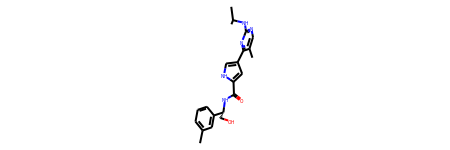

In [190]:
df_erk2_mols['conf_3i60_dk_pose'][0]

# USR or 3D D-MOMENTS 

In [ ]:
usr_descriptor_names =  ['Ctd-Mean', 'Ctd-Sigma', 'Ctd-Skewness',
                         'Cst-Mean', 'Cst-Sigma', 'Cst-Skewness', 
                         'Fct-Mean', 'Fct-Sigma', 'Fct-Skewness',
                         'Ftf-Mean', 'Ftf-Sigma', 'Ftf-Skewness']

### Computed for a minimized conformation

In [195]:
# Use the 'conf_3d_min' column computed above
# Compute USR/3-D MOMENTS descriptors for 3d min conformations
df_erk2_mols['dMoments_3d_min'] = [rdMolDescriptors.GetUSR(i) for i in df_erk2_mols.conf_3d_min]

### Computed from the best pose using the 3i60 conformation (the one used by Fourches)

In [196]:
# Compute USR/3-D MOMENTS descriptors for 3i60 poses
df_erk2_mols['dMoments_3i60_dk_pose'] = [rdMolDescriptors.GetUSR(i) for i in df_erk2_mols.conf_3i60_dk_pose]